<a href="https://colab.research.google.com/github/Mark-Barbaric/IntermediateMachineLearning/blob/master/CMAR10_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score

drive.mount('/content/drive')
pd.options.display.float_format = '{:,.2f}'.format

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Introduction

Useful articles on this dataset

https://thecleverprogrammer.com/2022/02/22/online-payments-fraud-detection-with-machine-learning/
https://towardsdatascience.com/extremely-imbalanced-data-fraud-detection-a5cc989fd897
https://databricks.com/discover/pages/detecting-financial-fraud-at-scale-with-decision-trees-and-ml-flow-on-databricks

#Custom Methods

In [2]:
def missing_data(data):
  total = data.isnull().sum().sort_values(ascending = False)
  percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
  ms = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  ms = ms[ms['Percent'] > 0]

  return ms

def pie_chart_from_value_counts(dataframe, column_name, chart_title):
  data = dataframe[column_name].value_counts()
  values = data.values
  names = data.index

  pie_chart = px.pie(dataframe,
                       values = values,
                       names = names, hole = 0.5,
                       title = chart_title)
  pie_chart.show()

# 1. **Import and Remove and Tidy Missing Data**

In [3]:
transaction_data = pd.read_csv('/content/drive/MyDrive/Intermediate Machine Learning/Week 2/bank_transactions.csv', thousands=',')
print(transaction_data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9,839.64  C1231006815     170,136.00      160,296.36   
1     1   PAYMENT  1,864.28  C1666544295      21,249.00       19,384.72   
2     1  TRANSFER    181.00  C1305486145         181.00            0.00   
3     1  CASH_OUT    181.00   C840083671         181.00            0.00   
4     1   PAYMENT 11,668.14  C2048537720      41,554.00       29,885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  M1979787155            0.00            0.00        0  
1  M2044282225            0.00            0.00        0  
2   C553264065            0.00            0.00        1  
3    C38997010       21,182.00            0.00        1  
4  M1230701703            0.00            0.00        0  


In [4]:
transaction_data.isna().sum()

step              0
type              6
amount            6
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [5]:
transaction_data.dropna(subset=['type', 'amount'], inplace=True)
transaction_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
99994,10,PAYMENT,62.19,C559473129,"215,097.09","215,034.89",M1361246816,0.00,0.00,1
99995,10,PAYMENT,"4,020.66",C1410794718,"159,929.00","155,908.34",M1257036576,0.00,0.00,0
99996,10,PAYMENT,"18,345.49",C744303677,"6,206.00",0.00,M1785344556,0.00,0.00,0
99997,10,CASH_IN,"183,774.91",C104331851,"39,173.00","222,947.91",C36392889,"54,925.05",0.00,0


In [6]:
transaction_data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [7]:
transaction_data.columns =['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig', 'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest', 'isFraud']

# **Transaction Breakdown**

In [8]:
pie_chart_from_value_counts(transaction_data, 'type', 'Transaction Data Transactions')

In [9]:
fraudulent_data = transaction_data.loc[transaction_data['isFraud'] == 1].copy()
print(fraudulent_data.head())

     step      type     amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
2       1  TRANSFER     181.00  C1305486145          181.00            0.00   
3       1  CASH_OUT     181.00   C840083671          181.00            0.00   
63      1   PAYMENT   2,599.46   C885910946      874,042.26      871,442.79   
117     1  CASH_OUT 419,801.40  C1687354037       38,197.63            0.00   
212     1  CASH_OUT  91,379.93   C913065088            0.00            0.00   

        nameDest  oldBalanceDest  newBalanceDest  isFraud  
2     C553264065            0.00            0.00        1  
3      C38997010       21,182.00            0.00        1  
63   M1860591867            0.00            0.00        1  
117    C33524623      499,962.00    1,517,262.16        1  
212   C401424608    1,241,634.38    1,178,808.14        1  


In [10]:
print(transaction_data['isFraud'].value_counts(normalize=True)* 100)

0   99.87
1    0.13
Name: isFraud, dtype: float64


Fraudulent Transactions represent .13% of total transactions.

In [11]:
print(transaction_data['step'].value_counts(normalize=True) * 100)

9    37.63
10   27.27
8    21.10
7     6.84
1     2.70
6     1.66
2     1.01
5     0.67
4     0.57
3     0.55
Name: step, dtype: float64


# **Fraudulent Transaction Analysis**

In [12]:
pie_chart_from_value_counts(fraudulent_data, 'type', 'Fraudulent Transaction Data')

The majority of fraudulent transactions are represented by TRANSFER and CASH_OUT.

In [13]:
correlation = transaction_data.corr()
print(correlation['isFraud'].sort_values(ascending=False))

isFraud           1.00
amount            0.04
oldBalanceOrig   -0.01
newBalanceDest   -0.01
oldBalanceDest   -0.01
newBalanceOrig   -0.01
step             -0.05
Name: isFraud, dtype: float64


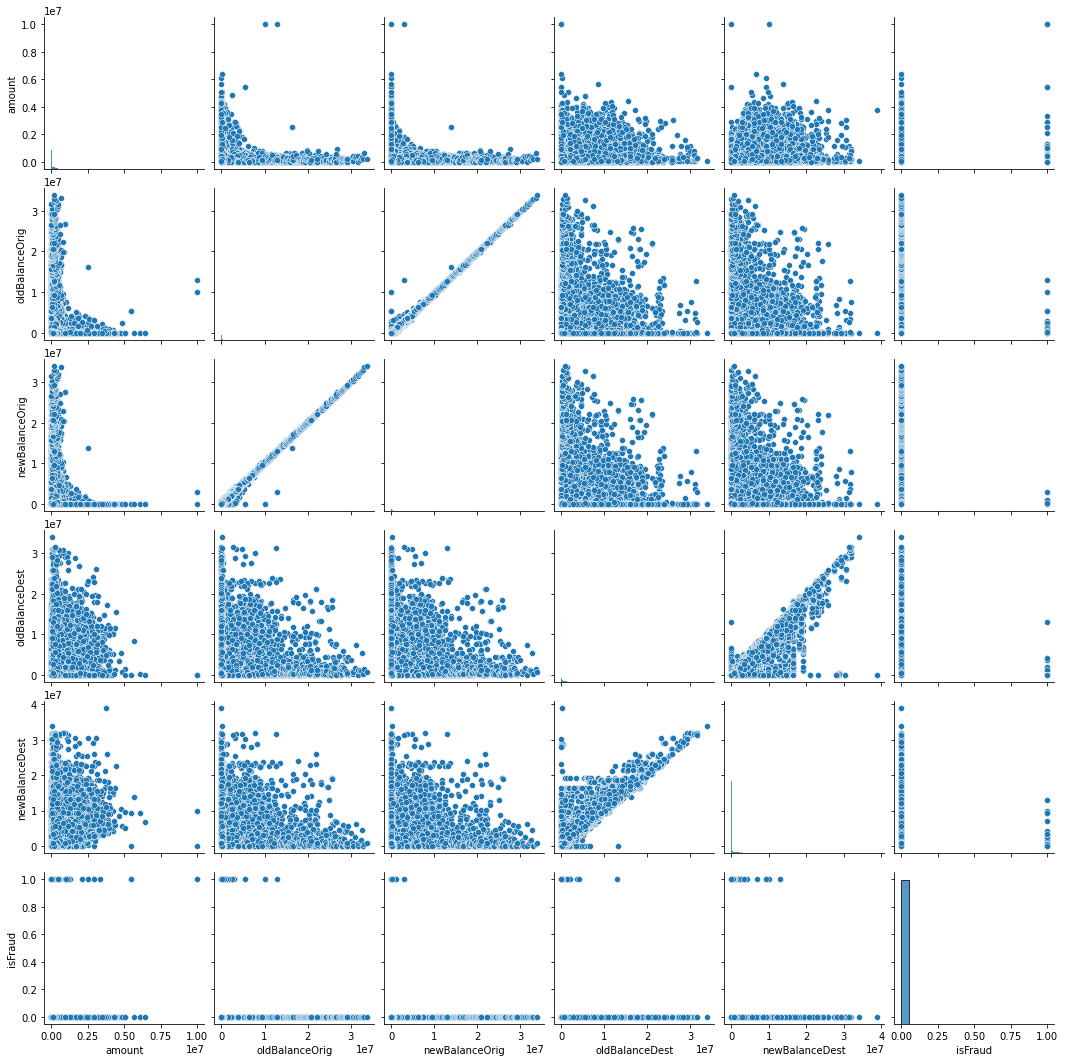

In [14]:
plot_transactions = transaction_data[['amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest', 'isFraud']]
sb.pairplot(plot_transactions)

Seems to be a very strong positive correlation between old balance and new balance for origin and destination.

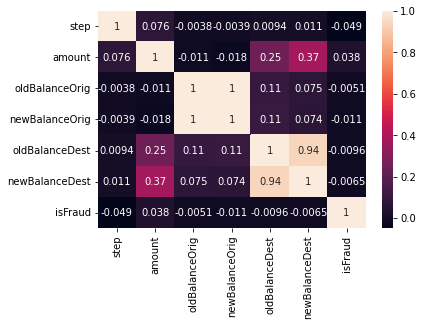

In [15]:
sb.heatmap(transaction_data.corr(),annot=True)

Heatmap indicates the below:

1. Strong correlation between Type and Amount, oldBalanceOrig and newBalanceOrig.
2. Very strong positive correlation between oldbalanceDest and newbalanceDest

Preparation of Data for Machine Learning

# **Fraud Detection Model**

One-hot encoded transaction type.

In [16]:
normalized_transaction_data = transaction_data.copy()
output = normalized_transaction_data['isFraud']
normalized_transaction_data = normalized_transaction_data[['type', 'amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest']]
normalized_transaction_data = pd.get_dummies(normalized_transaction_data, columns=['type'])
print(normalized_transaction_data.head())

     amount  oldBalanceOrig  newBalanceOrig  oldBalanceDest  newBalanceDest  \
0  9,839.64      170,136.00      160,296.36            0.00            0.00   
1  1,864.28       21,249.00       19,384.72            0.00            0.00   
2    181.00          181.00            0.00            0.00            0.00   
3    181.00          181.00            0.00       21,182.00            0.00   
4 11,668.14       41,554.00       29,885.86            0.00            0.00   

   type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0             0              0           0             1              0  
1             0              0           0             1              0  
2             0              0           0             0              1  
3             0              1           0             0              0  
4             0              0           0             1              0  


Finally need to normalize transaction amount so it can be modelled easier.

In [17]:
normalized_transaction_data['amount'] = normalized_transaction_data['amount'] / max(normalized_transaction_data['amount'])
normalized_transaction_data['oldBalanceOrig'] = normalized_transaction_data['oldBalanceOrig'] / max(normalized_transaction_data['oldBalanceOrig'])
normalized_transaction_data['newBalanceOrig'] = normalized_transaction_data['newBalanceOrig'] / max(normalized_transaction_data['newBalanceOrig'])
normalized_transaction_data['oldBalanceDest'] = normalized_transaction_data['oldBalanceDest'] / max(normalized_transaction_data['oldBalanceDest'])
normalized_transaction_data['newBalanceDest'] = normalized_transaction_data['newBalanceDest'] / max(normalized_transaction_data['newBalanceDest'])
print(normalized_transaction_data.head())

   amount  oldBalanceOrig  newBalanceOrig  oldBalanceDest  newBalanceDest  \
0    0.00            0.01            0.00            0.00            0.00   
1    0.00            0.00            0.00            0.00            0.00   
2    0.00            0.00            0.00            0.00            0.00   
3    0.00            0.00            0.00            0.00            0.00   
4    0.00            0.00            0.00            0.00            0.00   

   type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0             0              0           0             1              0  
1             0              0           0             1              0  
2             0              0           0             0              1  
3             0              1           0             0              0  
4             0              0           0             1              0  


In [18]:
dataframe = np.array(normalized_transaction_data)
dataframe

array([[9.83964000e-04, 5.03360947e-03, 4.71459882e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.86428000e-04, 6.28668639e-04, 5.70138824e-04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.81000000e-05, 5.35502959e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.83454900e-03, 1.83609467e-04, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.83774910e-02, 1.15896450e-03, 6.55729147e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.22371700e-03, 1.78431953e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [19]:
model_output = np.array(output).ravel()
model_output

array([0, 0, 1, ..., 0, 0, 0])

# **Training and Testing of Model**

In [20]:
train_features, test_features, train_labels, test_labels = train_test_split(dataframe, model_output, test_size=0.2, random_state=42)

In [21]:
model = RandomForestClassifier(n_estimators=20)
model.fit(train_features, train_labels)
predictions = model.predict(test_features)

In [22]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))
print ("Accuracy", accuracy_score(test_labels,predictions))
print(classification_report(test_labels,predictions))
print(confusion_matrix(test_labels, predictions))
accuracy_score(test_labels,predictions)

Mean Absolute Error: 0.0008000800080008001
Mean Squared Error: 0.0008000800080008001
Root Mean Squared Error: 0.028285685567099133
Accuracy 0.9991999199919992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.92      0.42      0.58        26

    accuracy                           1.00     19998
   macro avg       0.96      0.71      0.79     19998
weighted avg       1.00      1.00      1.00     19998

[[19971     1]
 [   15    11]]


0.9991999199919992

Model accuracy of 99% seems unlikely. Most likely being cause by bias in the dataset given that only .13% of transactions are fraudulent.

Use roc_auc_score, which represents the area under the ROC cruse, which is the curve having False Positive Rate on x-axis and True Positive Rate on y-axis.

In [25]:
roc_auc_score(test_labels, predictions)

0.7115134264893929

# **Undersampling Non Fraudulent Cases**